# Page rank

## Imports

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
import graphviz as gv

## Network classes

In [3]:
class Page:
    """A class representing a webpage."""
    def __init__(self, name):
        """Constructor method, takes the name of the webpage as an argument."""
        self.name = name
        self.links = []
        
    def __repr__(self):
        """A page is represented by its name."""
        return self.name
    
    def addLinkTo(self, other):
        """Adds a link to another page"""
        self.links.append(other)
        
    def outDegree(self):
        """Returns the amount of links this page has i.e. its out-degree"""
        return len(self.links)

In [4]:
class Network:
    """A class representing a network of webpages"""
    def __init__(self):
        """A network starts without any pages."""
        self.pages = []
        self.counter = 0
    
    def __iter__(self):
        """Iterating over a network is the same as iterating over its pages."""
        return iter(self.pages)
    
    def addPage(self, page: Page):
        """Adds a page to the network"""
        # give the page an id (since the name of the webpage doesn't have to be unique)
        page.id = self.counter
        self.counter += 1
        self.pages.append(page)
        
    def addPages(self, *args):
        """Adds multiple pages to the network"""
        for page in args:
            self.addPage(page)
        
    def getPages(self):
        """Returns the pages in the network."""
        return self.pages
    
    def size(self):
        """Returns the size of the network."""
        return len(self.pages)
    
    def showRanking(self):
        """
        Prints the pages with their corresponding rank. 
        Not sorted on anything in particular, prints in increasing id.
        """
        for page in self:
            print(f'{page.name}: {page.rank}')
            
    # --------------------- VISUALIZATION -------------------
    
    def nxDiGraph(self):
        """Calculates networkx DiGraph"""
        # make a directed graph
        G = nx.DiGraph()
        
        # add all the edges and nodes to it
        for page in self:
            G.add_node(page)
            for other in page.links:
                G.add_edge(page, other)
        
        return G
    
    def plot1(self, names=False):
        """
        Plot using networkx.
        Node size based on *number of links*
        """
        G = self.nxDiGraph()
        
        # calculate a layout (force-directed)
        pos = nx.layout.spring_layout(G)

        # scale nodes by amount of links
        node_sizes = [1000 + 3000*len(page.links) for page in G.nodes()]
        
        if not names:
            # labels
            labels = {page:page.id for page in G.nodes()}
            
            nx.draw(G, pos, with_labels=True, labels=labels, node_size=node_sizes, arrowsize=40, font_color="white")
        else:
            nx.draw(G, pos, with_labels=True, node_size=node_sizes, arrowsize=40, font_color="white")
        plt.show()
    
    def plot2(self):
        """Plot using networkx. Node size based on *rank*"""
        G = self.nxDiGraph()
        
        # calculate a layout (force-directed)
        pos = nx.layout.spring_layout(G)

        # scale nodes by amount of links
        node_sizes = [1000 + 3000*page.rank for page in G.nodes()]
        
        # labels
        labels = {page:page.id for page in G.nodes()}
        
        nx.draw(G, pos, with_labels=True, labels=labels, node_size=node_sizes, arrowsize=40, font_color="white")
        plt.show()
        
    def plot0(self):
        """Plot using graphviz"""
        f = gv.Digraph()
        for page in self:
            f.node(str(page))
            for other in page.links:
                f.edge(str(page), str(other))

        return f

### Example

In [5]:
wiki = Page("Wikipedia")
yt = Page("YouTube")
twitter = Page("Twitter")

wiki.addLinkTo(yt)
wiki.addLinkTo(twitter)
yt.addLinkTo(twitter)
twitter.addLinkTo(yt)

In [6]:
internet = Network()
internet.addPages(yt, wiki, twitter)

In [7]:
pages = internet.getPages()
pages

[YouTube, Wikipedia, Twitter]

In [8]:
pages[1].links

[YouTube, Twitter]

In [9]:
with open("california.txt") as f:
    content = f.read().splitlines()

In [10]:
california = Network()
for line in content:
    if line[0] == 'n':
        california.addPage(Page(line.split()[2]))
    elif line[0] == 'e':
        n1 = california.pages[int(line.split()[1])]
        n2 = california.pages[int(line.split()[2])]
        
        n1.addLinkTo(n2)

## Ranking the pages

In [11]:
class PageRanker:
    """A static class for ranking a network."""
    
    @staticmethod
    def rank(network: Network, steps: int, alpha: float):
        """
        Ranks a network via the PageRank algorithm.
        
        --- Parameters ---
        network: The Network to rank.
        steps: The number of iterations to do.
        alpha: The probability of going to another page via clicking a link.
        """
        PageRanker.calculateInitialRanking(network)
        PageRanker.calculateJumpingProbabilities(network)
        
        newRanks = {}
        for _ in range(0, steps):
            for page in network:
                newRanks[page] = 0
                for other in page.links:
                    newRanks[page] += other.rank / page.outDegree()
                newRanks[page] *= alpha
                newRanks[page] += (1-alpha) * page.q
                
        for page in network:
            page.rank = newRanks[page]
    
    @staticmethod
    def calculateInitialRanking(network: Network):
        """
        Calculates an initial ranking for the given network.
        Currently just gives each page a ranking of 1 / size of the network.
        """
        for page in network:
            page.rank = 1 / network.size()
            
    @staticmethod
    def calculateJumpingProbabilities(network: Network):
        """Calculates the probabilities of jumping to each page."""
        for page in network:
            page.q = 1 / network.size()

### Example

In [12]:
PageRanker.rank(internet, 1000, 0.5)

In [13]:
internet.showRanking()

YouTube: 0.3333333333333333
Wikipedia: 0.3333333333333333
Twitter: 0.3333333333333333


In [14]:
PageRanker.rank(california, 100, 0.5)

In [15]:
california.showRanking()

http://www.berkeley.edu/: 0.00010347682119205298
http://www.caltech.edu/: 0.00010347682119205298
http://www.realestatenet.com/: 0.00010347682119205298
http://www.ucsb.edu/: 0.00010347682119205297
http://www.washingtonpost.com/wp-srv/national/longterm/50states/ca.htm: 0.00010347682119205301
http://www-ucpress.berkeley.edu/: 0.00010347682119205298
http://www.ucr.edu/: 0.00010347682119205298
http://www.tegnetcorporation.com/: 0.00010347682119205298
http://www.research.digital.com/SRC/virtual-tourist/California.html: 0.00010347682119205298
http://www.leginfo.ca.gov/calaw.html: 5.173841059602649e-05
http://www.csun.edu/: 0.00010347682119205298
http://www.calpoly.edu/: 0.00010347682119205298
http://www.calbar.org/: 0.00010347682119205298
http://ideas.uqam.ca/ideas/data/fthcalaec.html: 5.173841059602649e-05
http://www.sen.ca.gov/: 0.00010347682119205298
http://www.csupomona.edu/: 5.173841059602649e-05
http://www.csuchico.edu/: 5.173841059602649e-05
http://www.calacademy.org/: 0.00010347682119

http://iranol.com/Science-Technology/CS-CE.html: 0.00010347682119205298
http://www.sims.berkeley.edu/resources/infoecon/Background.html: 0.00010347682119205298
http://www.bartelpc.com.au/orders.htm: 5.173841059602649e-05
http://ccn.cs.dal.ca/~ab006/html.html: 5.173841059602649e-05
http://www.pissedoff.com/crypto.shtml: 5.173841059602649e-05
http://www-ks.rus.uni-stuttgart.de/atp/standards.html: 0.00010347682119205298
http://www.uscsu.sc.edu/student_affairs/career.htm: 0.00010347682119205298
http://wings.buffalo.edu/sa/muslim/etc/career.html: 5.173841059602649e-05
http://www.csun.edu/career/otherweb.htm: 5.173841059602649e-05
http://www.harbornet.com/biz/office/alpha.html: 0.00010347682119205298
http://condor.depaul.edu/~cdc/oudepau1.html: 5.173841059602649e-05
http://www.surfinglinks.com/employ.htm: 5.173841059602649e-05
http://webcom.com/~career/guestbook.html: 5.173841059602649e-05
http://www.asae.org/jobs/: 0.00010347682119205298
http://www.shsu.edu/~org_shacs/jobs-list.html: 5.1738

http://www.jps.net/timem/thinblue/links.htm: 0.00010347682119205298
http://www.thegrid.net/code3/memor.html: 5.173841059602649e-05
http://www.house.gov/tauscher/prevtxt.htm: 5.173841059602649e-05
http://ourworld.compuserve.com/homepages/ACL_2/chuck.htm: 5.173841059602649e-05
http://www.tustinpd.org/other.html: 0.00010347682119205298
http://www.community.net/~locmup/: 0.00010347682119205298
http://www.thecpac.com/links.html: 0.00010347682119205298
http://dns.sas.ab.ca/memorial.html: 5.173841059602649e-05
http://www.ci.ssf.ca.us/police/contents/lawlinks.htm: 0.00010347682119205298
http://www.officer.com/memorial.htm: 0.00010347682119205298
http://www.ecis.com/~noslo/index.html: 0.00010347682119205298
http://www.belmont.gov/localgov/bpd/index.html: 5.173841059602649e-05
http://www.qnet.com/~harv/law.htm: 5.173841059602649e-05
http://members.aol.com/Suzanne01/posse.html: 0.00010347682119205298
http://www.xensei.com/users/hubcom/memorial.htm: 0.00010347682119205298
http://www.policeguide.co

http://www.cis.yale.edu/lawweb/apage.htm: 0.00010347682119205298
http://www.yale.edu/lawweb/apage.htm: 0.00010347682119205298
http://www.state.ky.us/agencies/nasire/STjudicial.html: 0.00010347682119205298
http://www.indiana.edu/~statepol/50states.html: 0.00010347682119205298
http://www.nasire.org/ss/STjudicial.html: 0.00010347682119205298
http://avalon.caltech.edu/~thanne/law.html: 0.00010347682119205298
http://www.jcu.edu.au/~blagd/misc.html: 5.173841059602649e-05
http://www.web-law.com/resources/stategov.html: 0.00010347682119205298
http://www.xensei.com/users/hubcom/resource.htm: 0.00010347682119205298
http://www.txlaw.com/state.html: 0.00010347682119205298
http://www.cio.com/central/legal.html: 0.00010347682119205298
http://www.execpc.com/~mshiller/othstates.html: 0.00010347682119205298
http://www.employers.org/erlinks.html: 0.00010347682119205298
http://www.officer.com/resource.htm: 0.00010347682119205298
http://www.cyberspace.org/~brenner/: 0.00010347682119205298
http://www.pacif

http://www.libertynet.org/ucrc/republican/state/stdir.html: 0.00010347682119205298
http://www.channel1.com/users/massgop/states.htm: 5.173841059602649e-05
http://www.yahoo.com/Regional/U_S__States/California/Government/Politics/Parties_and_Groups/Republican/index.html: 0.00010347682119205298
http://www.dartmouth.edu/~cuad/links.html: 5.173841059602649e-05
http://www.nrcc.org/fo/california.html: 5.173841059602649e-05
http://www.wenet.net/~bchoi/linksector.html: 5.173841059602649e-05
http://www.rnc.org/hq/stategop/cal.htm: 0.00010347682119205298
http://www.voxpop.org/jefferson/right/orgs/parties/: 5.173841059602649e-05
http://www.csusm.edu/student_orgs/Political_Science_Association/: 0.00010347682119205298
http://www.stetson.edu/~library/stparty.html: 0.00010347682119205298
http://www.mtsac.edu/~jholstie/: 5.173841059602649e-05
http://coyote.csusm.edu/student_orgs/Political_Science_Association/: 0.00010347682119205298
http://vote96.ss.ca.gov/BP/parties.htm: 0.00010347682119205298
http://

http://www.helsinki.fi//kmus/botvasc.html: 5.173841059602649e-05
http://www.igc.apc.org/envjustice/links/: 5.173841059602649e-05
http://www.ou.edu/cas/botany-micro/idb/botvasc.html: 5.173841059602649e-05
http://www.ualberta.ca/~ccinst/polar/cci-link.htm: 5.173841059602649e-05
http://www.avicom.net/ceri/aaa.html: 0.00010347682119205298
http://www.vol.it/mirror/kmus/botvasc.html: 5.173841059602649e-05
http://www.clarkson.edu/~knaebel/by321.html: 5.173841059602649e-05
http://www.fadr.msu.ru/~herba/mirrors/kmus/botvasc.html: 5.173841059602649e-05
http://darwin.bio.uci.edu/~sustain/bio65/makemark/PLANTS.html: 5.173841059602649e-05
http://darwin.eeb.uconn.edu/hotlist.html: 0.00010347682119205298
http://www.science.mcmaster.ca/Biology/CBCN/en/weblinks/: 5.173841059602649e-05
http://www.biol.uregina.ca/liu/bio/subject/botvasc.html: 5.173841059602649e-05
http://www.spiritone.com/~spotter/: 0.00010347682119205298
http://www.ons.com.au/~ezi-gro/links.htm: 5.173841059602649e-05
http://ucs.byu.edu/

## Visualization of (small) networks

### With networkx

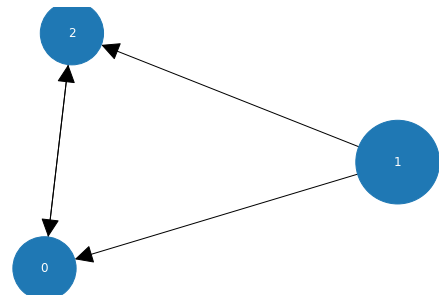

In [16]:
# size based on links
internet.plot1()

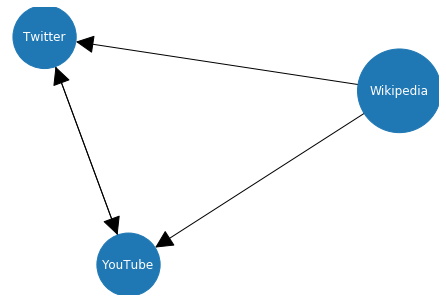

In [17]:
# plot with names (works in this case, but often labels are too large for the nodes)
internet.plot1(names=True)

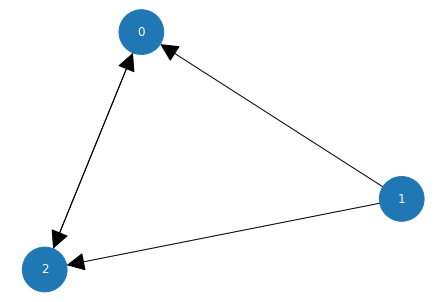

In [18]:
#size based on rank
internet.plot2()

### With graphviz

In [19]:
internet.plot0()

'C:\Users\20182530\Anaconda3\envs\Pagerank' is not recognized as an internal or external command,
operable program or batch file.


CalledProcessError: Command '['dot.bat', '-Tsvg']' returned non-zero exit status 1. [stderr: b"'C:\\Users\\20182530\\Anaconda3\\envs\\Pagerank' is not recognized as an internal or external command,\r\noperable program or batch file.\r\n"]

## Example with anomaly

In [20]:
#wiki = Page("Wikipedia")
#yt = Page("YouTube")
#twitter = Page("Twitter")

#wiki.addLinkTo(yt)
#wiki.addLinkTo(twitter)
#yt.addLinkTo(twitter)
#twitter.addLinkTo(yt)
#internet = Network()
#internet.addPages(yt, wiki, twitter)

internetV2= Network()
homepage = Page("Homepage")
for i in range(0,99):
    p = Page("test" + str(i))
    homepage.addLinkTo(p)
    internetV2.addPage(p)
internetV2.addPage(homepage)
PageRanker.rank(internetV2, 1000, 0.5)
internetV2.showRanking()

test0: 0.005
test1: 0.005
test2: 0.005
test3: 0.005
test4: 0.005
test5: 0.005
test6: 0.005
test7: 0.005
test8: 0.005
test9: 0.005
test10: 0.005
test11: 0.005
test12: 0.005
test13: 0.005
test14: 0.005
test15: 0.005
test16: 0.005
test17: 0.005
test18: 0.005
test19: 0.005
test20: 0.005
test21: 0.005
test22: 0.005
test23: 0.005
test24: 0.005
test25: 0.005
test26: 0.005
test27: 0.005
test28: 0.005
test29: 0.005
test30: 0.005
test31: 0.005
test32: 0.005
test33: 0.005
test34: 0.005
test35: 0.005
test36: 0.005
test37: 0.005
test38: 0.005
test39: 0.005
test40: 0.005
test41: 0.005
test42: 0.005
test43: 0.005
test44: 0.005
test45: 0.005
test46: 0.005
test47: 0.005
test48: 0.005
test49: 0.005
test50: 0.005
test51: 0.005
test52: 0.005
test53: 0.005
test54: 0.005
test55: 0.005
test56: 0.005
test57: 0.005
test58: 0.005
test59: 0.005
test60: 0.005
test61: 0.005
test62: 0.005
test63: 0.005
test64: 0.005
test65: 0.005
test66: 0.005
test67: 0.005
test68: 0.005
test69: 0.005
test70: 0.005
test71: 0.005
te

In [21]:
PageRanker.rank(internetV2, 1000, 0.1)
internetV2.showRanking()

test0: 0.009000000000000001
test1: 0.009000000000000001
test2: 0.009000000000000001
test3: 0.009000000000000001
test4: 0.009000000000000001
test5: 0.009000000000000001
test6: 0.009000000000000001
test7: 0.009000000000000001
test8: 0.009000000000000001
test9: 0.009000000000000001
test10: 0.009000000000000001
test11: 0.009000000000000001
test12: 0.009000000000000001
test13: 0.009000000000000001
test14: 0.009000000000000001
test15: 0.009000000000000001
test16: 0.009000000000000001
test17: 0.009000000000000001
test18: 0.009000000000000001
test19: 0.009000000000000001
test20: 0.009000000000000001
test21: 0.009000000000000001
test22: 0.009000000000000001
test23: 0.009000000000000001
test24: 0.009000000000000001
test25: 0.009000000000000001
test26: 0.009000000000000001
test27: 0.009000000000000001
test28: 0.009000000000000001
test29: 0.009000000000000001
test30: 0.009000000000000001
test31: 0.009000000000000001
test32: 0.009000000000000001
test33: 0.009000000000000001
test34: 0.00900000000000

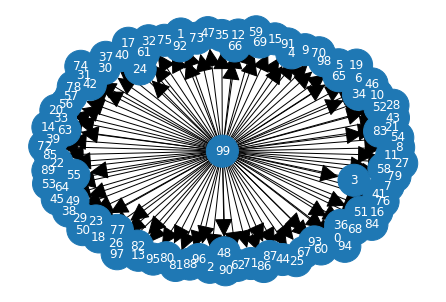

In [22]:
internetV2.plot2()

### Reverse

In [23]:
internetV3= Network()
endpage = Page("Endpage")
for i in range(0,99):
    p = Page("test" + str(i))
    p.addLinkTo(endpage)
    internetV3.addPage(p)
internetV3.addPage(endpage)
PageRanker.rank(internetV3, 1000, 0.5)
internetV3.showRanking()

test0: 0.01
test1: 0.01
test2: 0.01
test3: 0.01
test4: 0.01
test5: 0.01
test6: 0.01
test7: 0.01
test8: 0.01
test9: 0.01
test10: 0.01
test11: 0.01
test12: 0.01
test13: 0.01
test14: 0.01
test15: 0.01
test16: 0.01
test17: 0.01
test18: 0.01
test19: 0.01
test20: 0.01
test21: 0.01
test22: 0.01
test23: 0.01
test24: 0.01
test25: 0.01
test26: 0.01
test27: 0.01
test28: 0.01
test29: 0.01
test30: 0.01
test31: 0.01
test32: 0.01
test33: 0.01
test34: 0.01
test35: 0.01
test36: 0.01
test37: 0.01
test38: 0.01
test39: 0.01
test40: 0.01
test41: 0.01
test42: 0.01
test43: 0.01
test44: 0.01
test45: 0.01
test46: 0.01
test47: 0.01
test48: 0.01
test49: 0.01
test50: 0.01
test51: 0.01
test52: 0.01
test53: 0.01
test54: 0.01
test55: 0.01
test56: 0.01
test57: 0.01
test58: 0.01
test59: 0.01
test60: 0.01
test61: 0.01
test62: 0.01
test63: 0.01
test64: 0.01
test65: 0.01
test66: 0.01
test67: 0.01
test68: 0.01
test69: 0.01
test70: 0.01
test71: 0.01
test72: 0.01
test73: 0.01
test74: 0.01
test75: 0.01
test76: 0.01
test77: 0